<a href="https://colab.research.google.com/github/RenatoMaximiano/Trabalho_ADP2/blob/main/Algoritmo1_Desbalanceado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#***Projeto final  Modelagem Preditiva e Descritiva I***

***Alunos:*** Bernardo Morales, Renato Maximiano, Luiz Menezes.

***Banco de Dados:*** [Red-Wine-Quality](https://www.openml.org/search?type=data&status=active&qualities.NumberOfInstances=between_1000_10000&sort=runs&order=asc&id=43695)

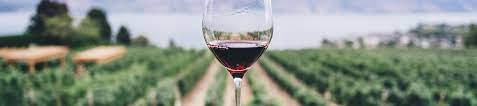

#***A atividade***

Selecionar um banco de dados do OpenML [openml](https://www.openml.org/)
     -- o banco de dados de classificação deve ter: > 3 classes, >10 atributos e >1000 instâncias
     -- cada dupla deve informar qual banco de dados usará com antecedência
-- 10-fold cross-validation
-- avaliar máquinas de aprendizagem: kNN, DT, MLP, NB e SVM
-- métricas (area under the ROC curve, f1-score, accuracy, matriz de confusão média)
-- opcional: para ajustar os parâmetros das máquinas de aprendizagem usar grid-search ou escolher os parâmetros e justificar
-- avaliar estratégias de seleção de instâncias, seleção de atributos e/ou de balanceamento
O relatório final deve conter pelo menos as seguintes informações:
  1. Introdução
  2. Conceitos básicos
  2.1. Algoritmos de Aprendizagem de Máquina
  2.2. Técnicas de pré-processamento
  3. Experimentos
  3.1.Banco de dados
  3.2.Métricas
  3.3. Resultados 
  4.Conclusões
  Referências


#***Introdução***

Para este trabalho vamos utilizar o banco de dados Red-Wine-Quality, o conjunto de dados está relacionado com variantes tinto e branco do vinho português "Vinho Verde". Por questões de privacidade e logística, apenas variáveis físico-químicas (entradas) e sensoriais (saídas) estão disponíveis (por exemplo, não há dados sobre tipos de uva, marca de vinho, preço de venda do vinho etc.). Esses conjuntos de dados podem ser vistos como tarefas de classificação ou regressão. As classes são ordenadas e não equilibradas (por exemplo, há muito mais vinhos normais do que excelentes ou pobres).
Variáveis de entrada (com base em testes físico-químicos): 1 - acidez fixa 2 - acidez volátil 3 - ácido cítrico 4 - açúcar residual 5 - cloretos 6 - dióxido de enxofre livre 7 - dióxido de enxofre total 8 - densidade 9 - pH 10 - sulfatos 11 – álcool. Variável de saída (baseada em dados sensoriais): 12 - qualidade (pontuação entre 0 e 10).
Para facilitar as análises definimos 3 classes com base nas pontuações dos vinhos. De 0 até 5 (Ruim), igual a 6 (Regular), de 7 até 10 (Bom).  Para este trabalho utilizamos o Optuna como otimizador de hiper parâmetros. Também aplicamos um 10-fold cross-validation dentro de cada iteração, utilizando a melhor média de acurácia para escolher os melhores hiper parâmetros e variamos  técnicas de balanceamento para aplicação.


#***Fluxograma***
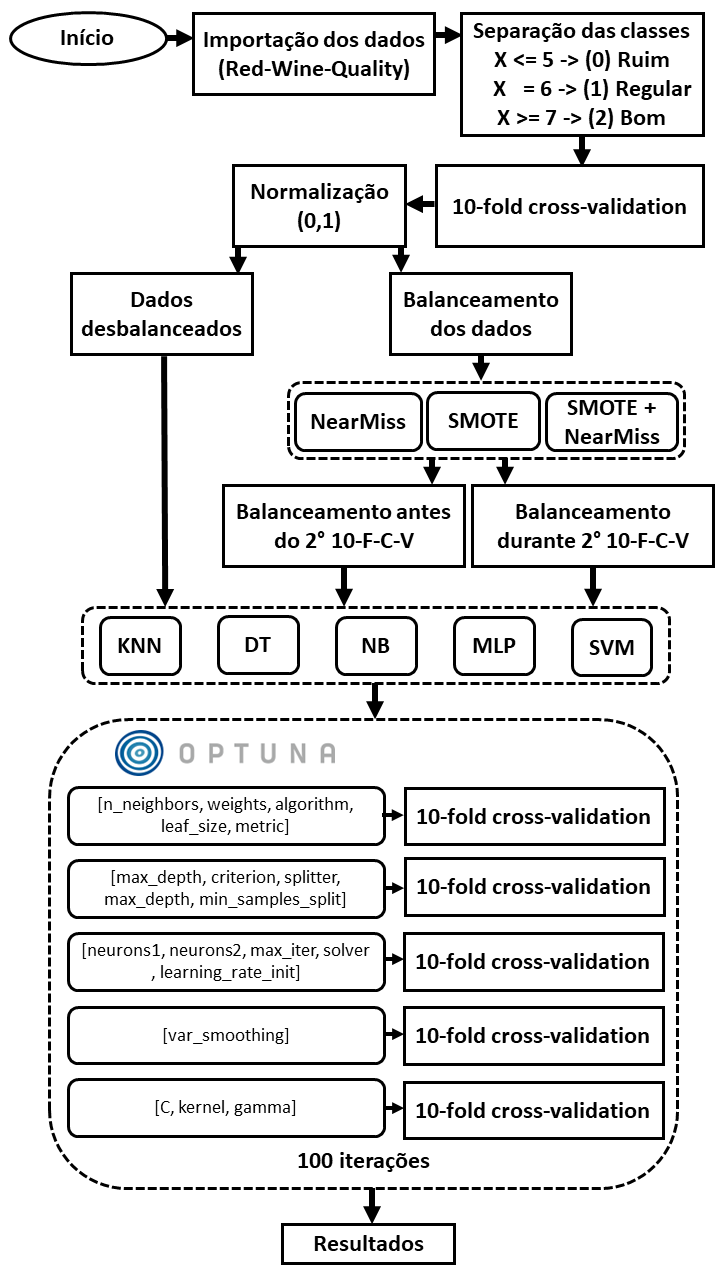

#***Bibliotecas utilizadas no projeto***

In [ ]:
pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Bibliotecas de manipualção e visualização de dados
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import seaborn as sns
from scipy.io.arff import loadarff 

#Classes do modelo de aprendizado
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB, ComplementNB
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from sklearn.svm import SVC

#Funções de avaliação dos modelos
from sklearn.metrics import classification_report, mean_squared_error, r2_score, accuracy_score, f1_score, plot_roc_curve, recall_score
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from keras.utils.np_utils import to_categorical
from sklearn.pipeline import Pipeline
import warnings
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

import optuna
from optuna.samplers import TPESampler
import random as python_random
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings('ignore')


In [ ]:
def reset_seeds():
   np.random.seed(4) 
   python_random.seed(9498)
   tf.random.set_seed(9)

reset_seeds() 

#***Banco de Dados***

Aqui é feito a importação dos dados, a separação das classes e as analises iniciais. 

In [ ]:
#Importação dos dados
raw_data = loadarff('/content/drive/MyDrive/Trabalho_APD/Red_wine')
df_data = pd.DataFrame(raw_data[0])

#Separação das classes.
df_data.loc[df_data["quality"] == 3, "quality"] = 0
df_data.loc[df_data["quality"] == 4, "quality"] = 0
df_data.loc[df_data["quality"] == 5, "quality"] = 0
df_data.loc[df_data["quality"] == 6, "quality"] = 1
df_data.loc[df_data["quality"] == 7, "quality"] = 2
df_data.loc[df_data["quality"] == 8, "quality"] = 2

#Analises iniciais
#df_data = df_data.apply(lambda x: x.str.decode('utf8'))
print("Quantas classes existem nesse dataset?\n%d" %(len(df_data["quality"].unique())))
print("\nQuantas instâncias existem no dataset?\n%d" %(len(df_data)))
print("\nQuantas features existem no dataset?\n%d" %(df_data.shape[1]))
print("\nQue features são essas?\n%s" %(str([k for k in df_data.keys()])))
print("\nQual o numero de instâncias por classe?")
print(df_data["quality"].value_counts())
dataset=df_data
df_data.head()

Quantas classes existem nesse dataset?
3

Quantas instâncias existem no dataset?
1599

Quantas features existem no dataset?
12

Que features são essas?
['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']

Qual o numero de instâncias por classe?
0.0    744
1.0    638
2.0    217
Name: quality, dtype: int64


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1.0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0.0


#***Visualização de espaço de parâmetros***

Confrontando feature por feature.

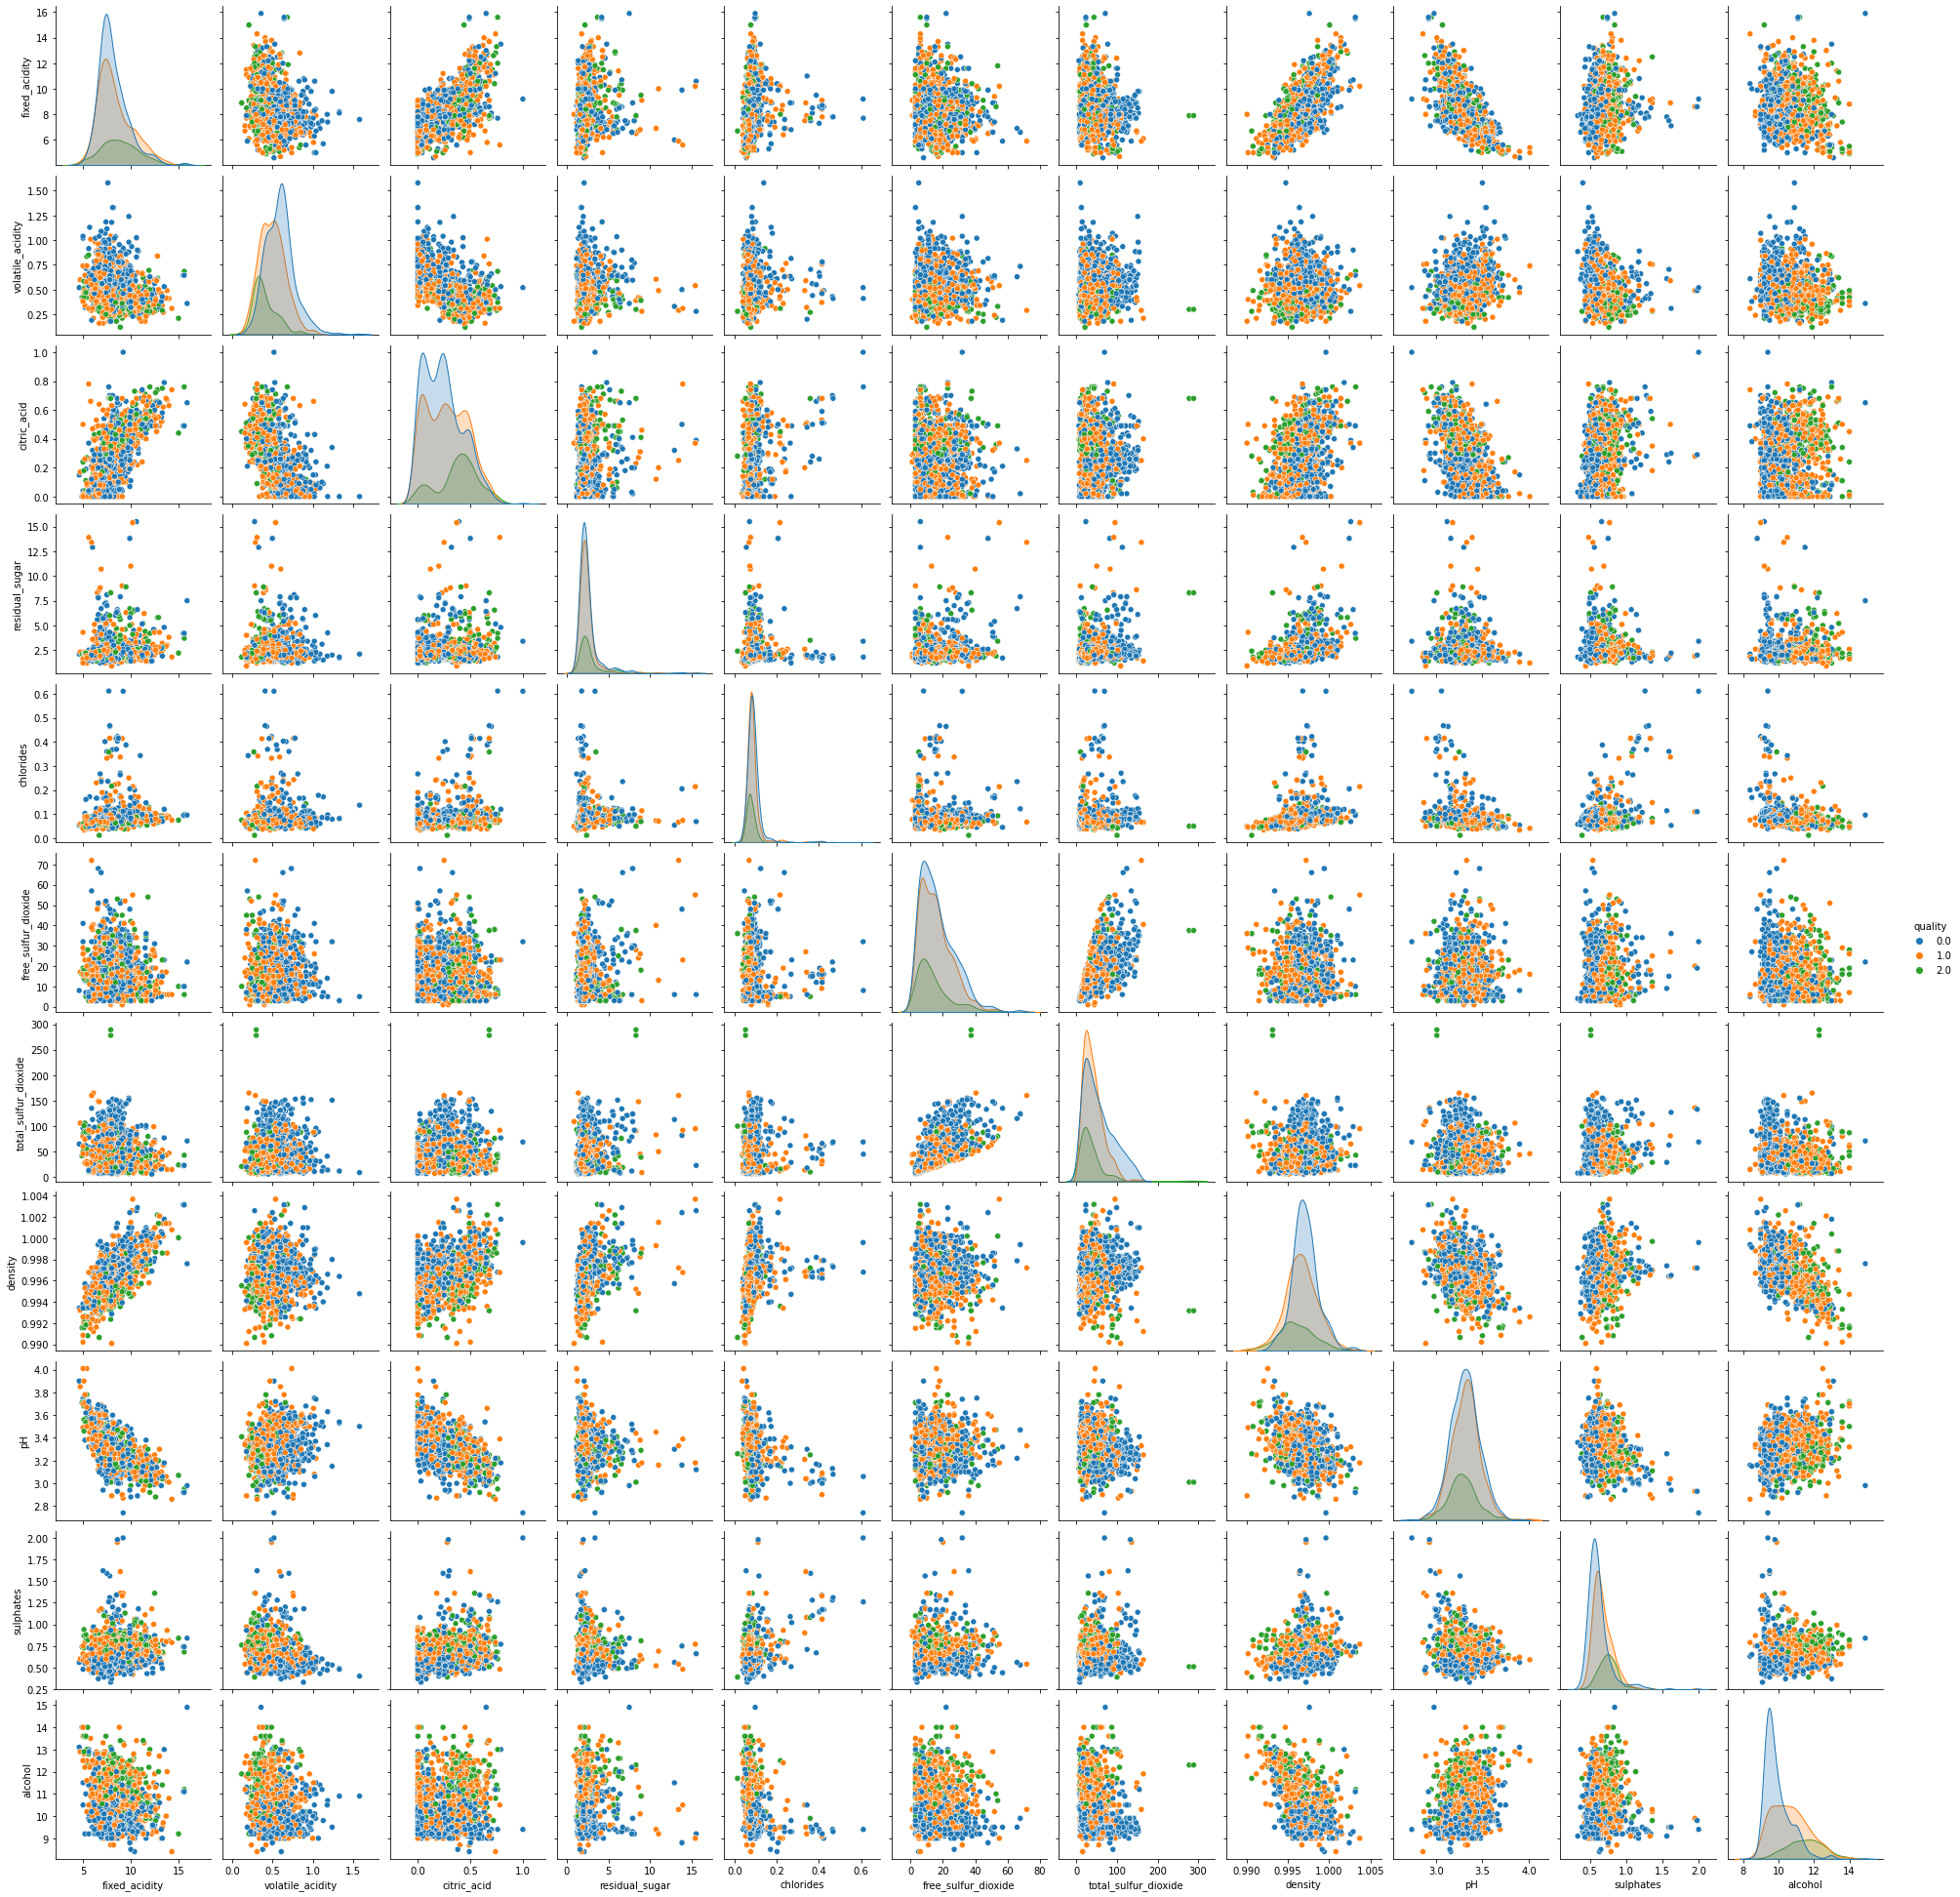

In [ ]:
sns.pairplot(data=df_data, vars=('fixed_acidity',	'volatile_acidity',	'citric_acid',	'residual_sugar',
                               'chlorides',	'free_sulfur_dioxide',	'total_sulfur_dioxide',	'density',	'pH',	'sulphates',	'alcohol'), hue='quality', palette=sns.color_palette()[:3])

#***Separando o Dataset em 10-Fold*** 

Obtendo os índices de forma misturada e aleatória, para o conjunto de treinamento e teste. Onde sempre teremos 9 para treinamento  vs 1 para teste. 

In [ ]:
#Aqui os índices são obtidos, guardados em suas respectivas listas de treinamento e teste, para serem utilizados posteriormente.
dataset=df_data
Train_index = []
Test_index = []
kf = StratifiedKFold(n_splits=10, random_state=9, shuffle=True)
for train_index, test_index in kf.split(dataset.iloc[:,[0,1,2,3,4,5,6,7,8,9,10]],dataset.iloc[:,[11]]):
   Train_index.append(train_index)
   Test_index.append(test_index)

In [ ]:
#Dividindo os dados de entrada dos dados alvos de interesse. 
X = dataset.iloc[:,[0,1,2,3,4,5,6,7,8,9,10]]
y = dataset.iloc[:,[11]]
def Train_test_Kfold(n):
  #Separando o conjunto de dados em treinamento e teste
  global Xtrain, ytrain, Xtest, ytest
  Xtrain, ytrain, Xtest, ytest = X.iloc[Train_index[n]], y.iloc[Train_index[n]], X.iloc[Test_index[n]], y.iloc[Test_index[n]]

#***KNN (K-Nearest Neighbors)***

**********************0**********************
[30, 'distance', 'ball_tree', 27, 'euclidean'] -> accuracy:0.74375 -> F1-Macro:0.7069431493101105recall score-macro:0.6981150793650794
**********************1**********************
[17, 'uniform', 'auto', 24, 'minkowski'] -> accuracy:0.58125 -> F1-Macro:0.529653064868817recall score-macro:0.5284424603174603
**********************2**********************
[21, 'distance', 'ball_tree', 40, 'minkowski'] -> accuracy:0.7125 -> F1-Macro:0.7093889753846995recall score-macro:0.7019817219817219
**********************3**********************
[24, 'distance', 'kd_tree', 36, 'minkowski'] -> accuracy:0.80625 -> F1-Macro:0.7686141462522244recall score-macro:0.7441462241462241
**********************4**********************
[29, 'distance', 'auto', 38, 'euclidean'] -> accuracy:0.73125 -> F1-Macro:0.7214654170299332recall score-macro:0.6964066339066339
**********************5**********************
[27, 'distance', 'kd_tree', 47, 'minkowski'] -> accuracy:0.6875 

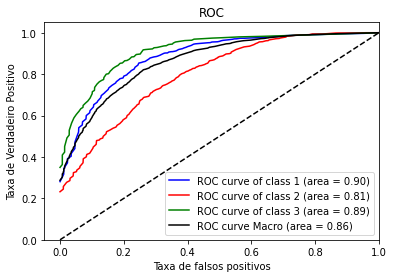

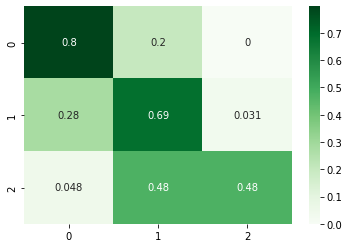

In [ ]:
#Definições de listas para gurdar os valores obtidos em cada iteração 
#Lista para as pontuações atingidas para cada iteração
Score_list = []
#Lista para as pontuações f1-Maxro atingidas para cada iteração
F1_macro   = []
#Lista para as pontuações recall_score atingidas para cada iteração
recall_score_macro = []
#Lista para as matrizes de confusão atingidas em cada iteração
cm_list    = []
#FRP, TPR, ROC_AUC da classe 1
FRP_0      = []
TPR_0      = []
ROC_auc_0  = []
#FRP, TPR, ROC_AUC da classe 2
FRP_1      = []
TPR_1      = []
ROC_auc_1  = []
#FRP, TPR, ROC_AUC da classe 3
FRP_2      = []
TPR_2      = []
ROC_auc_2  = []

#Importancia dos hiperparametros
h_0 = []
h_1 = []
h_2 = []
h_3 = []
h_4 = []

#Iniciando iterações
for i in range(10):
        #Chamada de cada fold 
        Train_test_Kfold(i)
        #Normalização dos dados
        scaler = MinMaxScaler(feature_range=(0, 1)) 
        Xtrain = scaler.fit_transform(Xtrain) 
        Xtest = scaler.transform(Xtest)
        Best = 0.0
        reset_seeds()
        def objective(trial):         
          #Busca de hiperparametros utilizando o Optruna como otimizador
          n_neighbors = trial.suggest_int("n_neighbors", 1, 30)
          weights     = trial.suggest_categorical("weights", ['uniform', 'distance'])
          algorithm   = trial.suggest_categorical("algorithm", ["auto", "ball_tree", "kd_tree", "brute"])
          leaf_size   = trial.suggest_int("leaf_size", 20, 50)
          metric      = trial.suggest_categorical("metric", ['euclidean', 'manhattan', 'minkowski'])

          #Modelo Utilizado -> KNN
          model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, algorithm=algorithm, leaf_size=leaf_size, metric=metric)

          #Variaveis globais
          global Best
          global Model
          global Lista

          #Inicializando Kfold-CrossValidation. (Utilizando 9/10 do conjunto de dados)
          kfold = StratifiedKFold(n_splits=10)
          score = cross_val_score(model, Xtrain, ytrain, scoring='accuracy', cv=kfold)
          #Pontuação media Obtida
          Score = score.mean()

          #Salvando a melhor pontuação da iteração e aplicando o fit no modelo
          if Score > Best:
            Best = Score
            model.fit(Xtrain, ytrain)
            Model = model
            Lista = [n_neighbors,weights,algorithm,leaf_size,metric]


          return Score

        #Chamada do Optuna 
        sampler = TPESampler(seed=42) 
        study = optuna.create_study(direction="maximize", sampler=sampler)
        #Definição do numero de iterações -> 100
        study.optimize(objective, n_trials=100)

        Importance = optuna.importance.get_param_importances(study)

        h_0.append(Importance["n_neighbors"])
        h_1.append(Importance["weights"])
        h_2.append(Importance["algorithm"])
        h_3.append(Importance["leaf_size"])
        h_4.append(Importance["metric"])
        

        #Ativação do modelo  para os dados de teste (1/10)
        ypred = Model.predict(Xtest)
        #Obtenção da Acurácia, F1-Score Macro e Matriz de confusão
        Acc = accuracy_score(ytest, ypred)
        F1 = f1_score(ytest, ypred, average='macro')
        rs = recall_score(ytest, ypred, average='macro')
        cm = confusion_matrix(ytest, ypred, normalize="true")
        #Append dos resultados obtidos na iteração
        Score_list.append(Acc)
        F1_macro.append(F1)
        recall_score_macro.append(rs)
        cm_list.append(cm)

        #Obtenção dos dados para curva ROC -> https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
        y_score = Model.predict_proba(Xtest)
        y_test = label_binarize(ytest, classes=[0,1,2])
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for j in range(3):
          fpr[j], tpr[j], _ = roc_curve(y_test[:, j], y_score[:, j])
          roc_auc[j] = auc(fpr[j], tpr[j])
        FRP_0.append(fpr[0])
        TPR_0.append(tpr[0])
        ROC_auc_0.append(roc_auc[0])
        FRP_1.append(fpr[1])
        TPR_1.append(tpr[1])
        ROC_auc_1.append(roc_auc[1])
        FRP_2.append(fpr[2])
        TPR_2.append(tpr[2])
        ROC_auc_2.append(roc_auc[2])

        print("**********************"+str(i)+"**********************")
        print(str(Lista)+ " -> accuracy:"+str(Acc)+ " -> F1-Macro:"+ str(F1)+ "recall score-macro:"+ str(rs))

#Criação da matriz de confusão media
cm_sum = cm_list[0]
for i in range(9):
  cm_sum = cm_list[i+1]+cm_sum
cm_mean= cm_sum/10

#Criação da curva ROC media
all_fpr_0 =np.unique(np.concatenate([FRP_0[i] for i in range(10)]))

mean_tpr_0 = np.zeros_like(all_fpr_0)
for i in range(10):
    mean_tpr_0 += np.interp(all_fpr_0,FRP_0[i], TPR_0[i])
mean_tpr_0 /= 10

all_fpr_1 =np.unique(np.concatenate([FRP_1[i] for i in range(10)]))

mean_tpr_1 = np.zeros_like(all_fpr_1)
for i in range(10):
    mean_tpr_1 += np.interp(all_fpr_1,FRP_1[i], TPR_1[i])
mean_tpr_1 /= 10


all_fpr_2 =np.unique(np.concatenate([FRP_2[i] for i in range(10)]))

mean_tpr_2 = np.zeros_like(all_fpr_2)
for i in range(10):
    mean_tpr_2 += np.interp(all_fpr_2,FRP_2[i], TPR_2[i])
mean_tpr_2 /= 10

FRP = [all_fpr_0,all_fpr_1,all_fpr_2]
TPR = [mean_tpr_0,mean_tpr_1,mean_tpr_2]

all_fpr =np.unique(np.concatenate([FRP[i] for i in range(3)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(3):
    mean_tpr += np.interp(all_fpr,FRP[i], TPR[i])
mean_tpr /= 3

#Pontuações e desvio padrão
print("Acuracia: %.2f%% (%.2f%%)" % (np.array(Score_list).mean()*100,np.array(Score_list).std()*100))
print("F1-Score Macro: %.2f%% (%.2f%%)" % (np.array(F1_macro).mean()*100, np.array(F1_macro).std()*100))
print("recall score macro: %.2f%% (%.2f%%)" % (np.array(recall_score_macro).mean()*100, np.array(recall_score_macro).std()*100))
print("n_neighbors: %.2f%%, weights: %.2f%%, algorithm: %.2f%%, leaf_size: %.2f%%, metric: %.2f%%" % (np.array(h_0).mean(), np.array(h_1).mean(), np.array(h_2).mean(),np.array(h_3).mean(),np.array(h_4).mean()))
#Plots Finais
roc_auc[3] = (auc(all_fpr, mean_tpr))
colors = cycle(['blue', 'red', 'green'])
a= [all_fpr_0,all_fpr_1,all_fpr_2, all_fpr]
b = [mean_tpr_0,mean_tpr_1,mean_tpr_2, mean_tpr]
for i, color in zip(range(3), colors):
    plt.plot(a[i], b[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))

plt.plot(a[3], b[3], color="black",
             label='ROC curve Macro (area = {1:0.2f})'
             ''.format(1, roc_auc[3]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de falsos positivos')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()
f = sns.heatmap(cm, annot=True, cmap="Greens")

#***DT (Decision tree)***

**********************0**********************
[13, 'entropy', 'random', 2, 3] -> accuracy:0.6375 -> F1-Macro:0.5712548589654141recall score-macro:0.5608333333333333
**********************1**********************
[12, 'entropy', 'random', 4, 3] -> accuracy:0.5625 -> F1-Macro:0.5133207923339121recall score-macro:0.4968353174603175
**********************2**********************
[10, 'entropy', 'random', 3, 3] -> accuracy:0.625 -> F1-Macro:0.6342414202047418recall score-macro:0.6231265031265031
**********************3**********************
[10, 'gini', 'random', 3, 3] -> accuracy:0.6125 -> F1-Macro:0.5523046157436174recall score-macro:0.5457623857623858
**********************4**********************
[11, 'entropy', 'random', 4, 2] -> accuracy:0.6125 -> F1-Macro:0.5558235313498731recall score-macro:0.5420121826371826
**********************5**********************
[11, 'entropy', 'random', 2, 2] -> accuracy:0.5625 -> F1-Macro:0.5237286420081099recall score-macro:0.5308788902538902
**************

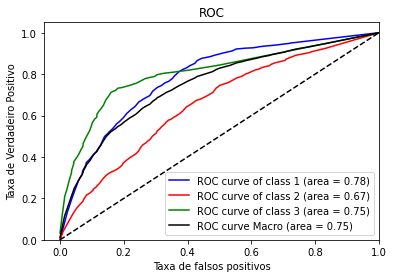

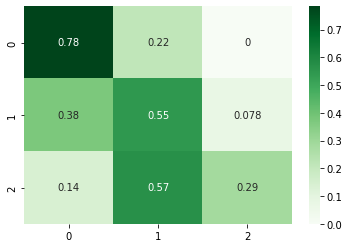

In [ ]:
#Definições de listas para guardar os valores obtidos em cada iteração 
#Lista para as pontuações atingidas para cada iteração
Score_list = []
#Lista para as pontuações f1-Maxro atingidas para cada iteração
F1_macro   = []
#Lista para as pontuações recall_score atingidas para cada iteração
recall_score_macro = []
#Lista para as matrizes de confusão atingidas em cada iteração
cm_list    = []
#FRP, TPR, ROC_AUC da classe 1
FRP_0      = []
TPR_0      = []
ROC_auc_0  = []
#FRP, TPR, ROC_AUC da classe 2
FRP_1      = []
TPR_1      = []
ROC_auc_1  = []
#FRP, TPR, ROC_AUC da classe 3
FRP_2      = []
TPR_2      = []
ROC_auc_2  = []

#Importancia dos hiperparametros
h_0 = []
h_1 = []
h_2 = []
h_3 = []
h_4 = []

#Iniciando iterações
for i in range(10):
        #Chamada de cada fold 
        Train_test_Kfold(i)
        #Normalização dos dados
        scaler = MinMaxScaler(feature_range=(0, 1)) 
        Xtrain = scaler.fit_transform(Xtrain) 
        Xtest = scaler.transform(Xtest)
        Best = 0.0
        reset_seeds()
        def objective(trial):         
          #Busca de hiperparametros utilizando o Optruna como otimizador
          max_depth = trial.suggest_int("max_depth", 10,20)
          criterion     = trial.suggest_categorical("criterion", ['gini', 'entropy'])
          splitter   = trial.suggest_categorical("splitter", ["best", "random"])
          min_samples_split   = trial.suggest_int("min_samples_split", 2,5)
          min_samples_leaf   = trial.suggest_int("min_samples_leaf", 1, 3)

          #Modelo Utilizado -> KNN
          model = DecisionTreeClassifier(criterion=criterion, splitter=splitter, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

          #Variaveis globais
          global Best
          global Model
          global Lista

          #Inicializando Kfold-CrossValidation. (Utilizando 9/10 do conjunto de dados)
          kfold = StratifiedKFold(n_splits=10)
          score = cross_val_score(model, Xtrain, ytrain, scoring='accuracy', cv=kfold)
          #Pontuação media Obtida
          Score = score.mean()

          #Salvando a melhor pontuação da iteração e aplicando o fit no modelo
          if Score > Best:
            Best = Score
            model.fit(Xtrain, ytrain)
            Model = model
            Lista = [max_depth,criterion,splitter,min_samples_split,min_samples_leaf]


          return Score

        #Chamada do Optuna 
        sampler = TPESampler(seed=42) 
        study = optuna.create_study(direction="maximize", sampler=sampler)
        #Definição do numero de iterações -> 100
        study.optimize(objective, n_trials=100)

        Importance = optuna.importance.get_param_importances(study)

        h_0.append(Importance["max_depth"])
        h_1.append(Importance["criterion"])
        h_2.append(Importance["splitter"])
        h_3.append(Importance["min_samples_split"])
        h_4.append(Importance["min_samples_leaf"])
        

        #Ativação do modelo  para os dados de teste (1/10)
        ypred = Model.predict(Xtest)
        #Obtenção da Acurácia, F1-Score Macro e Matriz de confusão
        Acc = accuracy_score(ytest, ypred)
        F1 = f1_score(ytest, ypred, average='macro')
        rs = recall_score(ytest, ypred, average='macro')
        cm = confusion_matrix(ytest, ypred, normalize="true")
        #Append dos resultados obtidos na iteração
        Score_list.append(Acc)
        F1_macro.append(F1)
        recall_score_macro.append(rs)
        cm_list.append(cm)

        #Obtenção dos dados para curva ROC -> https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
        y_score = Model.predict_proba(Xtest)
        y_test = label_binarize(ytest, classes=[0,1,2])
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for j in range(3):
          fpr[j], tpr[j], _ = roc_curve(y_test[:, j], y_score[:, j])
          roc_auc[j] = auc(fpr[j], tpr[j])
        FRP_0.append(fpr[0])
        TPR_0.append(tpr[0])
        ROC_auc_0.append(roc_auc[0])
        FRP_1.append(fpr[1])
        TPR_1.append(tpr[1])
        ROC_auc_1.append(roc_auc[1])
        FRP_2.append(fpr[2])
        TPR_2.append(tpr[2])
        ROC_auc_2.append(roc_auc[2])

        print("**********************"+str(i)+"**********************")
        print(str(Lista)+ " -> accuracy:"+str(Acc)+ " -> F1-Macro:"+ str(F1)+ "recall score-macro:"+ str(rs))

#Criação da matriz de confusão media
cm_sum = cm_list[0]
for i in range(9):
  cm_sum = cm_list[i+1]+cm_sum
cm_mean= cm_sum/10

#Criação da curva ROC media
all_fpr_0 =np.unique(np.concatenate([FRP_0[i] for i in range(10)]))

mean_tpr_0 = np.zeros_like(all_fpr_0)
for i in range(10):
    mean_tpr_0 += np.interp(all_fpr_0,FRP_0[i], TPR_0[i])
mean_tpr_0 /= 10

all_fpr_1 =np.unique(np.concatenate([FRP_1[i] for i in range(10)]))

mean_tpr_1 = np.zeros_like(all_fpr_1)
for i in range(10):
    mean_tpr_1 += np.interp(all_fpr_1,FRP_1[i], TPR_1[i])
mean_tpr_1 /= 10


all_fpr_2 =np.unique(np.concatenate([FRP_2[i] for i in range(10)]))

mean_tpr_2 = np.zeros_like(all_fpr_2)
for i in range(10):
    mean_tpr_2 += np.interp(all_fpr_2,FRP_2[i], TPR_2[i])
mean_tpr_2 /= 10

FRP = [all_fpr_0,all_fpr_1,all_fpr_2]
TPR = [mean_tpr_0,mean_tpr_1,mean_tpr_2]

all_fpr =np.unique(np.concatenate([FRP[i] for i in range(3)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(3):
    mean_tpr += np.interp(all_fpr,FRP[i], TPR[i])
mean_tpr /= 3

#Pontuações e desvio padrão
print("Acuracia: %.2f%% (%.2f%%)" % (np.array(Score_list).mean()*100,np.array(Score_list).std()*100))
print("F1-Score Macro: %.2f%% (%.2f%%)" % (np.array(F1_macro).mean()*100, np.array(F1_macro).std()*100))
print("recall score macro: %.2f%% (%.2f%%)" % (np.array(recall_score_macro).mean()*100, np.array(recall_score_macro).std()*100))
print("max_depth: %.2f%%, criterion: %.2f%%, splitter: %.2f%%, min_samples_split: %.2f%%, min_samples_leaf: %.2f%%" % (np.array(h_0).mean(), np.array(h_1).mean(), np.array(h_2).mean(),np.array(h_3).mean(),np.array(h_4).mean()))
#Plots Finais
roc_auc[3] = (auc(all_fpr, mean_tpr))
colors = cycle(['blue', 'red', 'green'])
a= [all_fpr_0,all_fpr_1,all_fpr_2, all_fpr]
b = [mean_tpr_0,mean_tpr_1,mean_tpr_2, mean_tpr]
for i, color in zip(range(3), colors):
    plt.plot(a[i], b[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))

plt.plot(a[3], b[3], color="black",
             label='ROC curve Macro (area = {1:0.2f})'
             ''.format(1, roc_auc[3]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de falsos positivos')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()
f = sns.heatmap(cm, annot=True, cmap="Greens")

#***GNB (Gaussian Naive Bayes)***

**********************0**********************
[3.807947176588889e-09] -> accuracy:0.6625 -> F1-Macro:0.6470131421744325recall score-macro:0.6578472222222222
**********************1**********************
[3.807947176588889e-09] -> accuracy:0.625 -> F1-Macro:0.5848662651094262recall score-macro:0.5976587301587301
**********************2**********************
[3.807947176588889e-09] -> accuracy:0.58125 -> F1-Macro:0.5675493897963569recall score-macro:0.6058104858104858
**********************3**********************
[3.807947176588889e-09] -> accuracy:0.6625 -> F1-Macro:0.6285006130207369recall score-macro:0.6481000481000482
**********************4**********************
[3.807947176588889e-09] -> accuracy:0.56875 -> F1-Macro:0.5776597878541173recall score-macro:0.5807867526617526
**********************5**********************
[3.807947176588889e-09] -> accuracy:0.55 -> F1-Macro:0.5127371273712736recall score-macro:0.5232775389025389
**********************6**********************
[3.8079471765

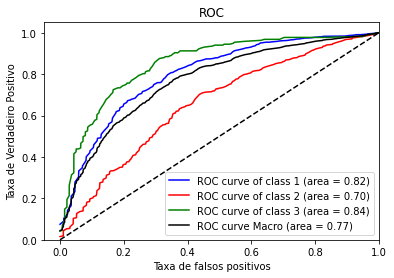

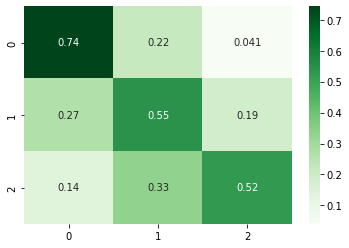

In [ ]:
#Definições de listas para gurdar os valores obtidos em cada iteração 
#Lista para as pontuações atingidas para cada iteração
Score_list = []
#Lista para as pontuações f1-Maxro atingidas para cada iteração
F1_macro   = []
#Lista para as pontuações recall_score atingidas para cada iteração
recall_score_macro = []
#Lista para as matrizes de confusão atingidas em cada iteração
cm_list    = []
#FRP, TPR, ROC_AUC da classe 1
FRP_0      = []
TPR_0      = []
ROC_auc_0  = []
#FRP, TPR, ROC_AUC da classe 2
FRP_1      = []
TPR_1      = []
ROC_auc_1  = []
#FRP, TPR, ROC_AUC da classe 3
FRP_2      = []
TPR_2      = []
ROC_auc_2  = []

#Importancia dos hiperparametros
h_0 = []
#Iniciando iterações
for i in range(10):
        #Chamada de cada fold 
        Train_test_Kfold(i)
        #Normalização dos dados
        scaler = MinMaxScaler(feature_range=(0, 1)) 
        Xtrain = scaler.fit_transform(Xtrain) 
        Xtest = scaler.transform(Xtest)
        Best = 0.0
        reset_seeds()
        def objective(trial):         
          #Busca de hiperparametros utilizando o Optruna como otimizador
          var_smoothing = trial.suggest_float("var_smoothing", 1e-10, 1e-08)

          #Modelo Utilizado -> KNN
          model = GaussianNB(var_smoothing=var_smoothing)

          #Variaveis globais
          global Best
          global Model
          global Lista

          #Inicializando Kfold-CrossValidation. (Utilizando 9/10 do conjunto de dados)
          kfold = StratifiedKFold(n_splits=10)
          score = cross_val_score(model, Xtrain, ytrain, scoring='accuracy', cv=kfold)
          #Pontuação media Obtida
          Score = score.mean()

          #Salvando a melhor pontuação da iteração e aplicando o fit no modelo
          if Score > Best:
            Best = Score
            model.fit(Xtrain, ytrain)
            Model = model
            Lista = [var_smoothing]


          return Score

        #Chamada do Optuna 
        sampler = TPESampler(seed=42) 
        study = optuna.create_study(direction="maximize", sampler=sampler)
        #Definição do numero de iterações -> 100
        study.optimize(objective, n_trials=100)




        

        #Ativação do modelo  para os dados de teste (1/10)
        ypred = Model.predict(Xtest)
        #Obtenção da Acurácia, F1-Score Macro e Matriz de confusão
        Acc = accuracy_score(ytest, ypred)
        F1 = f1_score(ytest, ypred, average='macro')
        rs = recall_score(ytest, ypred, average='macro')
        cm = confusion_matrix(ytest, ypred, normalize="true")
        #Append dos resultados obtidos na iteração
        Score_list.append(Acc)
        F1_macro.append(F1)
        recall_score_macro.append(rs)
        cm_list.append(cm)

        #Obtenção dos dados para curva ROC -> https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
        y_score = Model.predict_proba(Xtest)
        y_test = label_binarize(ytest, classes=[0,1,2])
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for j in range(3):
          fpr[j], tpr[j], _ = roc_curve(y_test[:, j], y_score[:, j])
          roc_auc[j] = auc(fpr[j], tpr[j])
        FRP_0.append(fpr[0])
        TPR_0.append(tpr[0])
        ROC_auc_0.append(roc_auc[0])
        FRP_1.append(fpr[1])
        TPR_1.append(tpr[1])
        ROC_auc_1.append(roc_auc[1])
        FRP_2.append(fpr[2])
        TPR_2.append(tpr[2])
        ROC_auc_2.append(roc_auc[2])

        print("**********************"+str(i)+"**********************")
        print(str(Lista)+ " -> accuracy:"+str(Acc)+ " -> F1-Macro:"+ str(F1)+ "recall score-macro:"+ str(rs))

#Criação da matriz de confusão media
cm_sum = cm_list[0]
for i in range(9):
  cm_sum = cm_list[i+1]+cm_sum
cm_mean= cm_sum/10

#Criação da curva ROC media
all_fpr_0 =np.unique(np.concatenate([FRP_0[i] for i in range(10)]))

mean_tpr_0 = np.zeros_like(all_fpr_0)
for i in range(10):
    mean_tpr_0 += np.interp(all_fpr_0,FRP_0[i], TPR_0[i])
mean_tpr_0 /= 10

all_fpr_1 =np.unique(np.concatenate([FRP_1[i] for i in range(10)]))

mean_tpr_1 = np.zeros_like(all_fpr_1)
for i in range(10):
    mean_tpr_1 += np.interp(all_fpr_1,FRP_1[i], TPR_1[i])
mean_tpr_1 /= 10


all_fpr_2 =np.unique(np.concatenate([FRP_2[i] for i in range(10)]))

mean_tpr_2 = np.zeros_like(all_fpr_2)
for i in range(10):
    mean_tpr_2 += np.interp(all_fpr_2,FRP_2[i], TPR_2[i])
mean_tpr_2 /= 10

FRP = [all_fpr_0,all_fpr_1,all_fpr_2]
TPR = [mean_tpr_0,mean_tpr_1,mean_tpr_2]

all_fpr =np.unique(np.concatenate([FRP[i] for i in range(3)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(3):
    mean_tpr += np.interp(all_fpr,FRP[i], TPR[i])
mean_tpr /= 3

#Pontuações e desvio padrão
print("Acuracia: %.2f%% (%.2f%%)" % (np.array(Score_list).mean()*100,np.array(Score_list).std()*100))
print("F1-Score Macro: %.2f%% (%.2f%%)" % (np.array(F1_macro).mean()*100, np.array(F1_macro).std()*100))
print("recall score macro: %.2f%% (%.2f%%)" % (np.array(recall_score_macro).mean()*100, np.array(recall_score_macro).std()*100))

#Plots Finais
roc_auc[3] = (auc(all_fpr, mean_tpr))
colors = cycle(['blue', 'red', 'green'])
a= [all_fpr_0,all_fpr_1,all_fpr_2, all_fpr]
b = [mean_tpr_0,mean_tpr_1,mean_tpr_2, mean_tpr]
for i, color in zip(range(3), colors):
    plt.plot(a[i], b[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))

plt.plot(a[3], b[3], color="black",
             label='ROC curve Macro (area = {1:0.2f})'
             ''.format(1, roc_auc[3]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de falsos positivos')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()
f = sns.heatmap(cm, annot=True, cmap="Greens")

#***MLP (Multilayer perceptron)***

**********************0**********************
[61, 85, 29, 'adam', 0.0007310463358543839] -> accuracy:0.6375 -> F1-Macro:0.5898630751964086recall score-macro:0.570734126984127
**********************1**********************
[86, 68, 29, 'adam', 0.0008412190697214533] -> accuracy:0.68125 -> F1-Macro:0.6440645161290323recall score-macro:0.639186507936508
**********************2**********************
[64, 65, 28, 'adam', 0.0009894604571516685] -> accuracy:0.6125 -> F1-Macro:0.55899615462457recall score-macro:0.5466089466089467
**********************3**********************
[80, 74, 30, 'adam', 0.0008474424692580206] -> accuracy:0.7 -> F1-Macro:0.6557129513352868recall score-macro:0.6451851851851852
**********************4**********************
[91, 94, 28, 'adam', 0.0008717527022891436] -> accuracy:0.575 -> F1-Macro:0.5303573607208675recall score-macro:0.5200015356265356
**********************5**********************
[98, 81, 30, 'adam', 0.0008769259144947468] -> accuracy:0.6375 -> F1-Macro:0

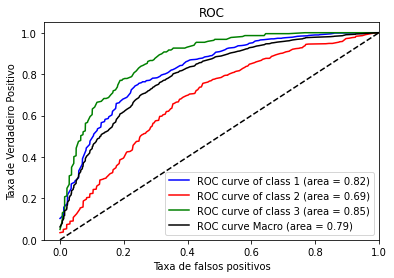

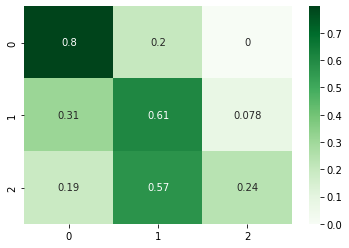

In [ ]:
#Definições de listas para gurdar os valores obtidos em cada iteração 
#Lista para as pontuações atingidas para cada iteração
Score_list = []
#Lista para as pontuações f1-Maxro atingidas para cada iteração
F1_macro   = []
#Lista para as pontuações recall_score atingidas para cada iteração
recall_score_macro = []
#Lista para as matrizes de confusão atingidas em cada iteração
cm_list    = []
#FRP, TPR, ROC_AUC da classe 1
FRP_0      = []
TPR_0      = []
ROC_auc_0  = []
#FRP, TPR, ROC_AUC da classe 2
FRP_1      = []
TPR_1      = []
ROC_auc_1  = []
#FRP, TPR, ROC_AUC da classe 3
FRP_2      = []
TPR_2      = []
ROC_auc_2  = []

#Importancia dos hiperparametros
h_0 = []
h_1 = []
h_2 = []
h_3 = []
h_4 = []

#Iniciando iterações
for i in range(10):
        #Chamada de cada fold 
        Train_test_Kfold(i)
        #Normalização dos dados
        scaler = MinMaxScaler(feature_range=(0, 1)) 
        Xtrain = scaler.fit_transform(Xtrain) 
        Xtest = scaler.transform(Xtest)
        Best = 0.0
        reset_seeds()
        def objective(trial):         
          #Busca de hiperparametros utilizando o Optruna como otimizador
          neurons1    = trial.suggest_int("neurons1", 50, 100)
          neurons2    = trial.suggest_int("neurons2", 50, 100)
          max_iter    = trial.suggest_int("max_iter", 10, 30)
          solver      = trial.suggest_categorical("solver", ['adam', 'sgd'])
          learning_rate_init   = trial.suggest_float("learning_rate_init", 0.0001, 0.001)


          #Modelo Utilizado -> MLP
          model = MLPClassifier(hidden_layer_sizes=(neurons1,neurons2), max_iter=max_iter,solver=solver, verbose=False,  learning_rate_init=learning_rate_init)

          #Variaveis globais
          global Best
          global Model
          global Lista

          #Inicializando Kfold-CrossValidation. (Utilizando 9/10 do conjunto de dados)
          kfold = StratifiedKFold(n_splits=10)
          score = cross_val_score(model, Xtrain, ytrain, scoring='accuracy', cv=kfold)
          #Pontuação media Obtida
          Score = score.mean()

          #Salvando a melhor pontuação da iteração e aplicando o fit no modelo
          if Score > Best:
            Best = Score
            model.fit(Xtrain, ytrain)
            Model = model
            Lista = [neurons1,neurons2,max_iter,solver,learning_rate_init]


          return Score

        #Chamada do Optuna 
        sampler = TPESampler(seed=42) 
        study = optuna.create_study(direction="maximize", sampler=sampler)
        #Definição do numero de iterações -> 100
        study.optimize(objective, n_trials=100)

        Importance = optuna.importance.get_param_importances(study)

        h_0.append(Importance["neurons1"])
        h_1.append(Importance["neurons2"])
        h_2.append(Importance["max_iter"])
        h_3.append(Importance["solver"])
        h_4.append(Importance["learning_rate_init"])
        

        #Ativação do modelo  para os dados de teste (1/10)
        ypred = Model.predict(Xtest)
        #Obtenção da Acurácia, F1-Score Macro e Matriz de confusão
        Acc = accuracy_score(ytest, ypred)
        F1 = f1_score(ytest, ypred, average='macro')
        rs = recall_score(ytest, ypred, average='macro')
        cm = confusion_matrix(ytest, ypred, normalize="true")
        #Append dos resultados obtidos na iteração
        Score_list.append(Acc)
        F1_macro.append(F1)
        recall_score_macro.append(rs)
        cm_list.append(cm)

        #Obtenção dos dados para curva ROC -> https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
        y_score = Model.predict_proba(Xtest)
        y_test = label_binarize(ytest, classes=[0,1,2])
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for j in range(3):
          fpr[j], tpr[j], _ = roc_curve(y_test[:, j], y_score[:, j])
          roc_auc[j] = auc(fpr[j], tpr[j])
        FRP_0.append(fpr[0])
        TPR_0.append(tpr[0])
        ROC_auc_0.append(roc_auc[0])
        FRP_1.append(fpr[1])
        TPR_1.append(tpr[1])
        ROC_auc_1.append(roc_auc[1])
        FRP_2.append(fpr[2])
        TPR_2.append(tpr[2])
        ROC_auc_2.append(roc_auc[2])

        print("**********************"+str(i)+"**********************")
        print(str(Lista)+ " -> accuracy:"+str(Acc)+ " -> F1-Macro:"+ str(F1)+ "recall score-macro:"+ str(rs))

#Criação da matriz de confusão media
cm_sum = cm_list[0]
for i in range(9):
  cm_sum = cm_list[i+1]+cm_sum
cm_mean= cm_sum/10

#Criação da curva ROC media
all_fpr_0 =np.unique(np.concatenate([FRP_0[i] for i in range(10)]))

mean_tpr_0 = np.zeros_like(all_fpr_0)
for i in range(10):
    mean_tpr_0 += np.interp(all_fpr_0,FRP_0[i], TPR_0[i])
mean_tpr_0 /= 10

all_fpr_1 =np.unique(np.concatenate([FRP_1[i] for i in range(10)]))

mean_tpr_1 = np.zeros_like(all_fpr_1)
for i in range(10):
    mean_tpr_1 += np.interp(all_fpr_1,FRP_1[i], TPR_1[i])
mean_tpr_1 /= 10


all_fpr_2 =np.unique(np.concatenate([FRP_2[i] for i in range(10)]))

mean_tpr_2 = np.zeros_like(all_fpr_2)
for i in range(10):
    mean_tpr_2 += np.interp(all_fpr_2,FRP_2[i], TPR_2[i])
mean_tpr_2 /= 10

FRP = [all_fpr_0,all_fpr_1,all_fpr_2]
TPR = [mean_tpr_0,mean_tpr_1,mean_tpr_2]

all_fpr =np.unique(np.concatenate([FRP[i] for i in range(3)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(3):
    mean_tpr += np.interp(all_fpr,FRP[i], TPR[i])
mean_tpr /= 3
#Pontuações e desvio padrão
print("Acuracia: %.2f%% (%.2f%%)" % (np.array(Score_list).mean()*100,np.array(Score_list).std()*100))
print("F1-Score Macro: %.2f%% (%.2f%%)" % (np.array(F1_macro).mean()*100, np.array(F1_macro).std()*100))
print("recall score macro: %.2f%% (%.2f%%)" % (np.array(recall_score_macro).mean()*100, np.array(recall_score_macro).std()*100))
print("neurons1: %.2f%%, neurons2: %.2f%%, max_iter: %.2f%%, solver: %.2f%%, learning_rate_init: %.2f%%" % (np.array(h_0).mean(), np.array(h_1).mean(), np.array(h_2).mean(),np.array(h_3).mean(),np.array(h_4).mean()))
#Plots Finais
roc_auc[3] = (auc(all_fpr, mean_tpr))
colors = cycle(['blue', 'red', 'green'])
a= [all_fpr_0,all_fpr_1,all_fpr_2, all_fpr]
b = [mean_tpr_0,mean_tpr_1,mean_tpr_2, mean_tpr]
for i, color in zip(range(3), colors):
    plt.plot(a[i], b[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))

plt.plot(a[3], b[3], color="black",
             label='ROC curve Macro (area = {1:0.2f})'
             ''.format(1, roc_auc[3]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de falsos positivos')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()
f = sns.heatmap(cm, annot=True, cmap="Greens")

#***SVM (Support Vector Machines)***

**********************0**********************
[1, 'rbf', 2.6678741756269524] -> accuracy:0.6375 -> F1-Macro:0.5459783774559992recall score-macro:0.5379761904761905
**********************1**********************
[1, 'rbf', 6.861882908918451] -> accuracy:0.675 -> F1-Macro:0.6085764747182071recall score-macro:0.6004563492063492
**********************2**********************
[1, 'rbf', 5.339272477170932] -> accuracy:0.65625 -> F1-Macro:0.6046803438107786recall score-macro:0.5827994227994228
**********************3**********************
[2, 'rbf', 3.052831271931403] -> accuracy:0.7 -> F1-Macro:0.6268254910645571recall score-macro:0.6057431457431457
**********************4**********************
[6, 'rbf', 3.992064210384264] -> accuracy:0.64375 -> F1-Macro:0.6127463017226796recall score-macro:0.5957719082719083
**********************5**********************
[2, 'rbf', 7.912001918633001] -> accuracy:0.66875 -> F1-Macro:0.5975012683916793recall score-macro:0.5789440008190009
**********************

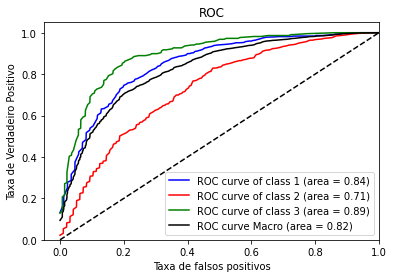

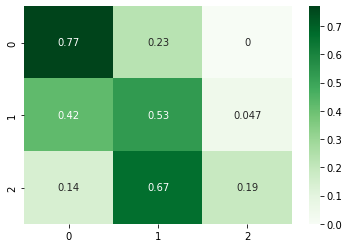

In [ ]:
#Definições de listas para gurdar os valores obtidos em cada iteração 
#Lista para as pontuações atingidas para cada iteração
Score_list = []
#Lista para as pontuações f1-Maxro atingidas para cada iteração
F1_macro   = []
#Lista para as pontuações recall_score atingidas para cada iteração
recall_score_macro = []
#Lista para as matrizes de confusão atingidas em cada iteração
cm_list    = []
#FRP, TPR, ROC_AUC da classe 1
FRP_0      = []
TPR_0      = []
ROC_auc_0  = []
#FRP, TPR, ROC_AUC da classe 2
FRP_1      = []
TPR_1      = []
ROC_auc_1  = []
#FRP, TPR, ROC_AUC da classe 3
FRP_2      = []
TPR_2      = []
ROC_auc_2  = []

#Importancia dos hiperparametros
h_0 = []
h_1 = []
h_2 = []


#Iniciando iterações
for i in range(10):
        #Chamada de cada fold 
        Train_test_Kfold(i)
        #Normalização dos dados
        scaler = MinMaxScaler(feature_range=(0, 1)) 
        Xtrain = scaler.fit_transform(Xtrain) 
        Xtest = scaler.transform(Xtest)
        Best = 0.0
        reset_seeds()
        def objective(trial):         
          #Busca de hiperparametros utilizando o Optruna como otimizador
          C = trial.suggest_int("C", 1, 10)
          kernel     = trial.suggest_categorical("kernel", ['linear','rbf', 'sigmoid'])
          gamma   = trial.suggest_float("gamma", 0.1, 10)

          #Modelo Utilizado -> SVN
          model = SVC(C=C, kernel=kernel, gamma=gamma,  random_state=0, probability=True)

          #Variaveis globais
          global Best
          global Model
          global Lista

          #Inicializando Kfold-CrossValidation. (Utilizando 9/10 do conjunto de dados)
          kfold = StratifiedKFold(n_splits=10)
          score = cross_val_score(model, Xtrain, ytrain, scoring='accuracy', cv=kfold)
          #Pontuação media Obtida
          Score = score.mean()

          #Salvando a melhor pontuação da iteração e aplicando o fit no modelo
          if Score > Best:
            Best = Score
            model.fit(Xtrain, ytrain)
            Model = model
            Lista = [C, kernel, gamma]


          return Score

        #Chamada do Optuna 
        sampler = TPESampler(seed=42) 
        study = optuna.create_study(direction="maximize", sampler=sampler)
        #Definição do numero de iterações -> 100
        study.optimize(objective, n_trials=100)

        Importance = optuna.importance.get_param_importances(study)

        h_0.append(Importance["C"])
        h_1.append(Importance["kernel"])
        h_2.append(Importance["gamma"])

        

        #Ativação do modelo  para os dados de teste (1/10)
        ypred = Model.predict(Xtest)
        #Obtenção da Acurácia, F1-Score Macro e Matriz de confusão
        Acc = accuracy_score(ytest, ypred)
        F1 = f1_score(ytest, ypred, average='macro')
        rs = recall_score(ytest, ypred, average='macro')
        cm = confusion_matrix(ytest, ypred, normalize="true")
        #Append dos resultados obtidos na iteração
        Score_list.append(Acc)
        F1_macro.append(F1)
        recall_score_macro.append(rs)
        cm_list.append(cm)

        #Obtenção dos dados para curva ROC -> https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
        y_score = Model.predict_proba(Xtest)
        y_test = label_binarize(ytest, classes=[0,1,2])
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for j in range(3):
          fpr[j], tpr[j], _ = roc_curve(y_test[:, j], y_score[:, j])
          roc_auc[j] = auc(fpr[j], tpr[j])
        FRP_0.append(fpr[0])
        TPR_0.append(tpr[0])
        ROC_auc_0.append(roc_auc[0])
        FRP_1.append(fpr[1])
        TPR_1.append(tpr[1])
        ROC_auc_1.append(roc_auc[1])
        FRP_2.append(fpr[2])
        TPR_2.append(tpr[2])
        ROC_auc_2.append(roc_auc[2])

        print("**********************"+str(i)+"**********************")
        print(str(Lista)+ " -> accuracy:"+str(Acc)+ " -> F1-Macro:"+ str(F1)+ "recall score-macro:"+ str(rs))

#Criação da matriz de confusão media
cm_sum = cm_list[0]
for i in range(9):
  cm_sum = cm_list[i+1]+cm_sum
cm_mean= cm_sum/10

#Criação da curva ROC media
all_fpr_0 =np.unique(np.concatenate([FRP_0[i] for i in range(10)]))

mean_tpr_0 = np.zeros_like(all_fpr_0)
for i in range(10):
    mean_tpr_0 += np.interp(all_fpr_0,FRP_0[i], TPR_0[i])
mean_tpr_0 /= 10

all_fpr_1 =np.unique(np.concatenate([FRP_1[i] for i in range(10)]))

mean_tpr_1 = np.zeros_like(all_fpr_1)
for i in range(10):
    mean_tpr_1 += np.interp(all_fpr_1,FRP_1[i], TPR_1[i])
mean_tpr_1 /= 10


all_fpr_2 =np.unique(np.concatenate([FRP_2[i] for i in range(10)]))

mean_tpr_2 = np.zeros_like(all_fpr_2)
for i in range(10):
    mean_tpr_2 += np.interp(all_fpr_2,FRP_2[i], TPR_2[i])
mean_tpr_2 /= 10

FRP = [all_fpr_0,all_fpr_1,all_fpr_2]
TPR = [mean_tpr_0,mean_tpr_1,mean_tpr_2]

all_fpr =np.unique(np.concatenate([FRP[i] for i in range(3)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(3):
    mean_tpr += np.interp(all_fpr,FRP[i], TPR[i])
mean_tpr /= 3

#Pontuações e desvio padrão
print("Acuracia: %.2f%% (%.2f%%)" % (np.array(Score_list).mean()*100,np.array(Score_list).std()*100))
print("F1-Score Macro: %.2f%% (%.2f%%)" % (np.array(F1_macro).mean()*100, np.array(F1_macro).std()*100))
print("recall score macro: %.2f%% (%.2f%%)" % (np.array(recall_score_macro).mean()*100, np.array(recall_score_macro).std()*100))
print("C: %.2f%%, kernel: %.2f%%, gamma: %.2f%%" % (np.array(h_0).mean(), np.array(h_1).mean(), np.array(h_2).mean()))
#Plots Finais
roc_auc[3] = (auc(all_fpr, mean_tpr))
colors = cycle(['blue', 'red', 'green'])
a= [all_fpr_0,all_fpr_1,all_fpr_2, all_fpr]
b = [mean_tpr_0,mean_tpr_1,mean_tpr_2, mean_tpr]
for i, color in zip(range(3), colors):
    plt.plot(a[i], b[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))

plt.plot(a[3], b[3], color="black",
             label='ROC curve Macro (area = {1:0.2f})'
             ''.format(1, roc_auc[3]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de falsos positivos')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()
f = sns.heatmap(cm, annot=True, cmap="Greens")